In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from myheatmap import myheatmap
import matplotlib as mpl
import scipy as sp

print(mpl.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = False


# source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))


3.1.2


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


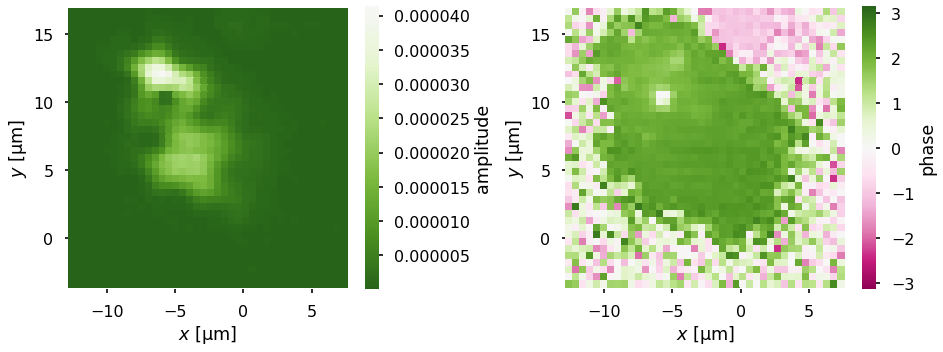

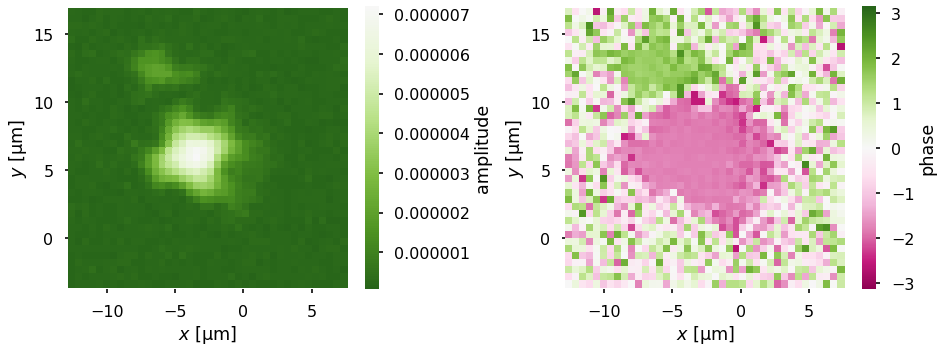

In [2]:
############### Mac vs Windows ##############
#folder1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
#folder2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/07/30/'
folder1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'
folder2 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\07\30'

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = (amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap='PiYG_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', vmin=-np.pi, vmax = np.pi, cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = amp2
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap='PiYG_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4) 
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', vmin=-np.pi, vmax = np.pi, cmap='PiYG');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


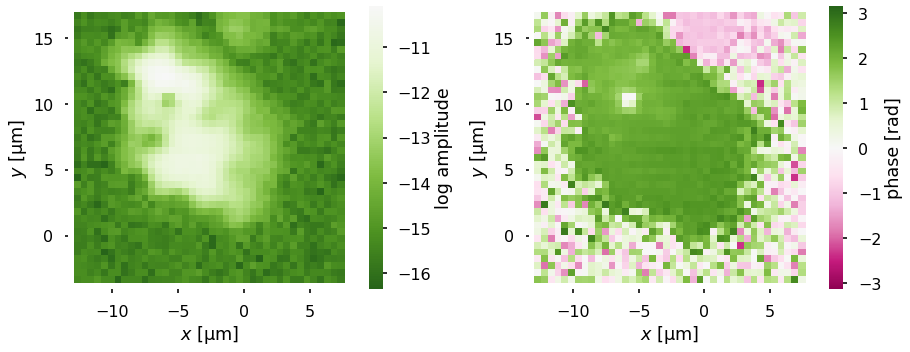

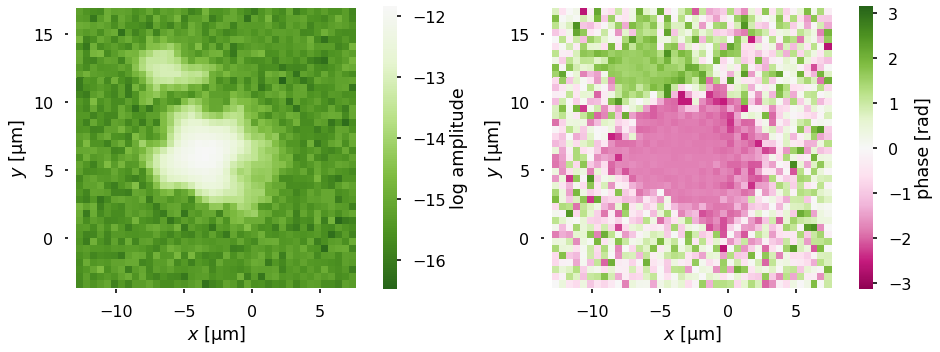

In [3]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap='PiYG_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase [rad]', vmin=-np.pi, vmax = np.pi, cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp2)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap='PiYG_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase [rad]',vmin=-np.pi, vmax = np.pi, cmap='PiYG');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


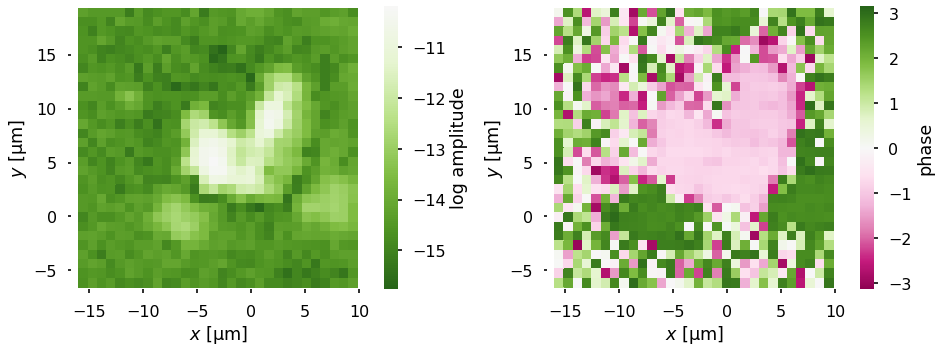

In [10]:
file = 'PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap='PiYG_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap='PiYG');
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();

3.0242059739999996


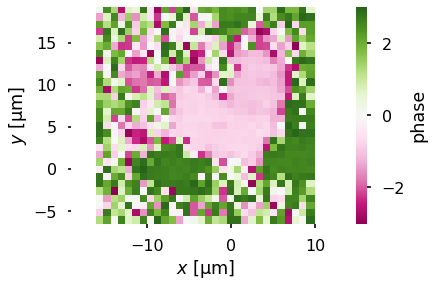

In [11]:
print(max(-np.array(phase1).min(),np.array(phase1).max()))

myheatmap(phase1, 'phase', 
          vmin=-max(-np.array(phase1).min(),np.array(phase1).max()), 
          vmax = max(-np.array(phase1).min(),np.array(phase1).max()), 
          cmap='PiYG');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

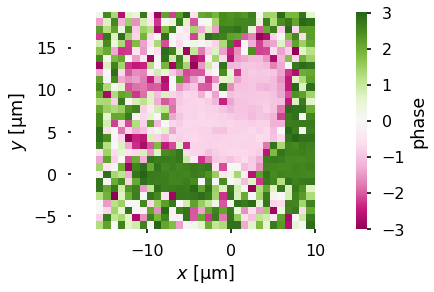

In [7]:

    
# set midpoint at zero.
vmin = np.array(phase1).min()
vmax = np.array(phase1).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)


## Plot with a norm at 0
myheatmap(phase1, 'phase', norm = norm,
          cmap='PiYG');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

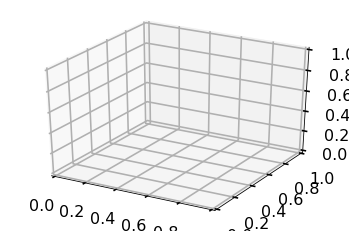

In [8]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(phase1.columns,phase1.index )
ax.plot_surface(X,Y,phase1, 
                norm=norm,  # set midpoint at 0.
                antialiased=False,
                cmap='PiYG' )
plt.xlabel(phase1.columns.name)
plt.ylabel(phase1.index.name)
ax.set_title(file);
ax.view_init(elev=60., azim=0)

In [ ]:
## Cut colorbar in half.

data = np.log(amp1)

# set white at max.
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)


## Plot with a midpoint at 0.
myheatmap(data, 'log amplitude', norm = greennorm,
          cmap='PiYG_r');
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

In [ ]:
myheatmap(np.log(amp1), 'log amplitude', cmap = 'YlGn_r');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(amp1.columns,amp1.index )
ax.plot_surface(X,Y,(amp1), 
                antialiased=False,
                cmap='YlGn_r', )
plt.xlabel(amp1.columns.name)
plt.ylabel(amp1.index.name)
ax.set_title(file);
ax.view_init(elev=60., azim=0)

In [ ]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()